In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from glob import glob
from scipy import linalg
import scipy.io
import os
import librosa
import librosa.display
import soundfile


In [2]:
# Import files from data folder

folder_paths = []
genres = []


for entry_name in os.listdir('data'):
    entry_path = os.path.join('data', entry_name)
    if os.path.isdir(entry_path):
        folder_paths.append(entry_path)
        genres.append(entry_name)
print(genres)
print(folder_paths)

['pop', 'metal', 'disco', 'blues', 'reggae', 'classical', 'rock', 'hiphop', 'country', 'jazz']
['data/pop', 'data/metal', 'data/disco', 'data/blues', 'data/reggae', 'data/classical', 'data/rock', 'data/hiphop', 'data/country', 'data/jazz']


In [3]:
# Create subsets of genres to restrict model to certain genres


sub = [0,1,2,3,4,5,6,7,8,9] # full set



folder_paths = [folder_paths[i] for i in sub]
genres = [genres[i] for i in sub]


print(genres)
print(folder_paths)

['pop', 'metal', 'disco', 'blues', 'reggae', 'classical', 'rock', 'hiphop', 'country', 'jazz']
['data/pop', 'data/metal', 'data/disco', 'data/blues', 'data/reggae', 'data/classical', 'data/rock', 'data/hiphop', 'data/country', 'data/jazz']


In [4]:
# Import all song files

files = []

for i in range(0,len(folder_paths)):
    files.append(glob(folder_paths[i]+'/*.wav'))

In [5]:
# Uses librosa to load the song files into wave format

waves = []
sr = []

for i in range(0,len(files)):
    wavelist = []
    for j in range(0,len(files[i])):
        yin,srin = librosa.load(files[i][j],duration=29)
        wavelist.append(yin)
    waves.append(wavelist)    

In [6]:
# Uses librosa to create Mel-Frequency cepstral coefficient matrices for each song

spectrums = []

for i in range(0,len(waves)):  
    spectrumlist = []
    for j in range(0,len(waves[i])):
        specin = librosa.feature.mfcc(y=waves[i][j])
        spectrumlist.append(specin)
    spectrums.append(spectrumlist)
    


In [7]:
# Randomly selects songs in each genre based on trainSetSize and splits in to training and test sets


trainSetSize = 30

trainIndex = np.random.choice(range(98), trainSetSize, replace=False)
testIndex = np.arange(0,98,1)
testIndex = list(filter(lambda x: x not in trainIndex, testIndex))

testSet = np.take(files[0],testIndex)
trainSet = np.take(files[0],trainIndex)


for i in trainIndex:
    print(i)


39
10
80
85
21
0
29
1
5
28
27
69
56
59
19
91
32
34
43
92
53
35
74
2
73
61
40
84
63
4


In [8]:
# Creates an average mfcc matrix of the training set for each genre, also creates an average mfcc matrix for the entire training basis 

averageSongs = []
averageSpectrum = []
iterations = 0
for i in range(0,len(genres)):
    average = []
    for j in trainIndex:
        if len(average) == 0:
            average = spectrums[i][j]
        else:
            average = average + spectrums[i][j]
        if len(averageSpectrum) == 0:
            averageSpectrum = spectrums[i][j]
        else:
            averageSpectrum = averageSpectrum + spectrums[i][j]  
        iterations = iterations + 1
    averageSongs.append(average*(1/trainSetSize))
averageSpectrum = averageSpectrum*(1/(trainSetSize*len(genres)))



In [9]:
# Creates a training basis for all songs in the training set for each genre in order.
# This will also be mean-centered

trainBases = []

for i in range(0,len(spectrums)):
    first = 1
    for j in trainIndex:
        if bool(first) == True:
            X = (spectrums[i][j]-averageSpectrum)
            first = 0
        else:
            X = np.concatenate((X,(spectrums[i][j]-averageSpectrum)),axis=1)
    trainBases.append(X)

Songs = []
for i in range(0,len(trainBases)):
    if len(Songs) == 0:
        Songs = trainBases[i]
    else:
        Songs = np.append(Songs,trainBases[i],axis=1)


In [10]:
# Performs SVD on the basis matrix

U,Sigma,V = np.linalg.svd(Songs,full_matrices=0)

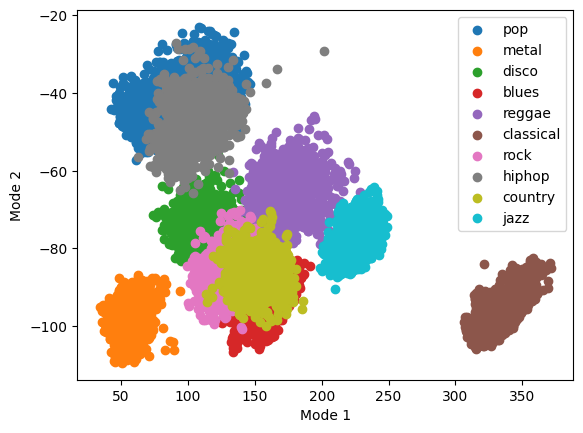

In [11]:
#performs PCA by projecting the average mfcc matrix of each genre onto the selected columns of U transpose.  

PCAmodes = [1,2]
PCACoords = []

for i in range(0,len(averageSongs)):
    PCACoords.append(U[:,PCAmodes-np.ones_like(PCAmodes)].T @ averageSongs[i])


for i in range(0,len(PCACoords)):
    plt.scatter(PCACoords[i][0,:],PCACoords[i][1,:],label=genres[i])


plt.xlabel("{}{}".format("Mode ", PCAmodes[0]))
plt.ylabel("{}{}".format("Mode ", PCAmodes[1]))
plt.legend()
plt.show()

In [12]:
# Performs classification by projecting each song in the test set and assigning a classificaiton based on the distance to each PCA cluster.

testClassif = []

for k in range(0,len(genres)):
    predictedValues = []
    print(genres[k])
    for j in testIndex:
        PCAtest = U[:,PCAmodes-np.ones_like(PCAmodes)].T @ spectrums[k][j]
        norms = []
        for i in range(0,len(genres)):
            norms.append(np.linalg.norm(PCAtest-PCACoords[i])) 
        predictedValues.append(np.argmin(norms))
    testClassif.append(predictedValues)

pop
metal
disco
blues
reggae
classical
rock
hiphop
country
jazz


In [13]:
# Calculates the correct classification rates for each genre.

classifRates = []
for i in range(0,len(testClassif)):
    sumCorrect = 0
    for k in range(0,len(testClassif[i])):
        if testClassif[i][k] == i:
            sumCorrect = sumCorrect + 1
    classifRates.append(sumCorrect/len(testClassif[i]))

classifRates

[0.6029411764705882,
 0.5441176470588235,
 0.22058823529411764,
 0.08823529411764706,
 0.3235294117647059,
 0.7941176470588235,
 0.20588235294117646,
 0.11764705882352941,
 0.07352941176470588,
 0.5147058823529411]